In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc3 as pm
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import theano.tensor as tt

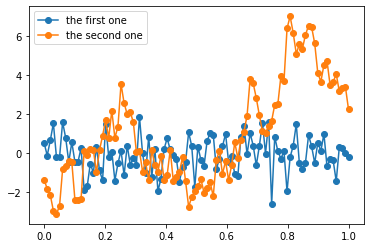

In [2]:
np.random.seed(42) #finally
x = np.linspace(0, 1, 100)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label = 'the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label = 'the second one')

plt.legend()
plt.plot();

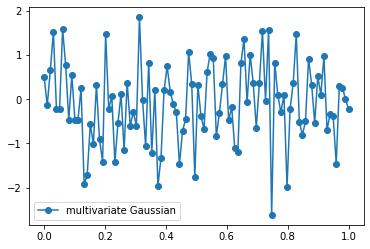

In [3]:
np.random.seed(42) #finally
x = np.linspace(0, 1, 100)

y = np.random.multivariate_normal(np.zeros_like(x), np.eye(len(x)))
plt.plot(x, y, 'o-', label = 'multivariate Gaussian')

plt.legend()
plt.plot();

We need a multivariate Gaussian with the right covariance structure.
To get these we use functions known as **kernels**.
For our purposes they take inputs and output a number that specifies the similarity of points. 
Exponential quadratic kernel is popular.

In [4]:
def exp_quad_kernel(x, knots, l = 1): 
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*l**2)) for k in knots])

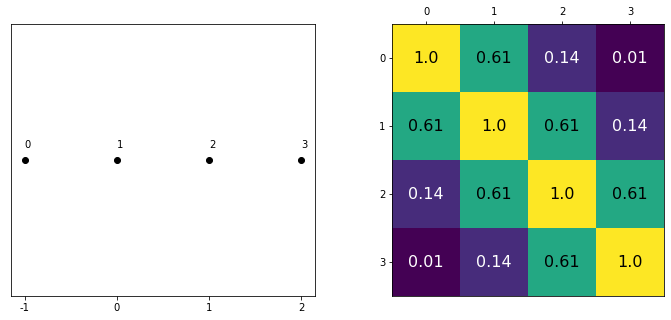

In [5]:
data = np.array([-1, 0, 1, 2])
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                  color = colors[int(im.norm(cov[i, j]) > 0.5)],
                  ha = 'center', va = 'center', fontdict = {'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

In [6]:
from scipy import stats

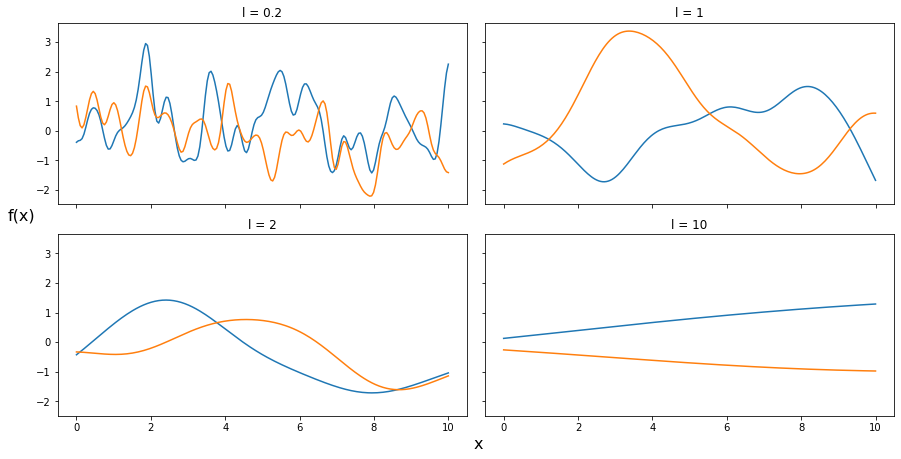

In [7]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize = (12, 6), 
                      sharex = True, sharey = True, 
                      constrained_layout = True)
ax = np.ravel(ax)
for idx, l in enumerate((0.2, 1, 2, 10)): 
    cov = exp_quad_kernel(test_points, test_points, l)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov = cov,
                                                           size = 2).T)
    ax[idx].set_title(f'l = {l}')

fig.text(0.51, -0.03, 'x', fontsize = 16)
fig.text(-0.03, 0.5, 'f(x)', fontsize = 16)
plt.plot();

Yeah, so the "l"-norm (as I suppose it is) controls regularization it seems.

# Gaussian processes (regression)

Text(0, 0.5, 'f(x)')

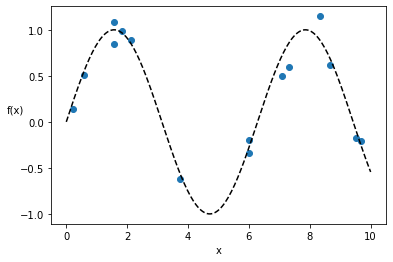

In [8]:
np.random.seed(42) # "random"
x = np.random.uniform(0, 10, size = 15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation = 0)

Recall that marginal likelihood is integral of likelihood & prior.

In [9]:
# one-dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for length scale kernel parameter
    l = pm.Gamma('l', 2, 0.5)
    
    # instantiate covariance function
    cov = pm.gp.cov.ExpQuad(1, ls = l)
    
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func = cov)
    
    # prior 
    ϵ = pm.HalfNormal('ϵ', 25)
    
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X = X, y = y, noise = ϵ)

In [10]:
with model_reg:
    
    trace = pm.sample(1000)
    post = pm.sample_posterior_predictive(trace, samples = 50)
    prior = pm.sample_prior_predictive(samples = 50)
    
    md = {'model': model_reg, 
         'trace': trace,
         'prior': prior,
         'post': post}

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
/home/victormp/.local/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'l'}>,
        <AxesSubplot:title={'center':'l'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

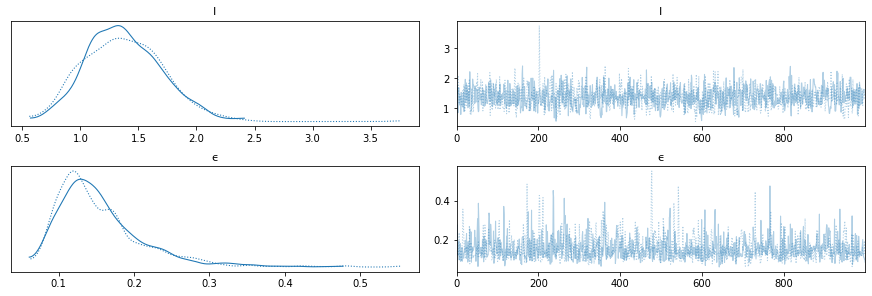

In [11]:
az.plot_trace(md.get('trace'))

In [12]:
# conditional distribution evaluated over new input locations
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:, None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [13]:
# now works
with model_reg:
    pred_samples = pm.sample_posterior_predictive(md.get('trace'), 
                                                 var_names = ["f_pred"], 
                                                 samples = 82)

/home/victormp/.local/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


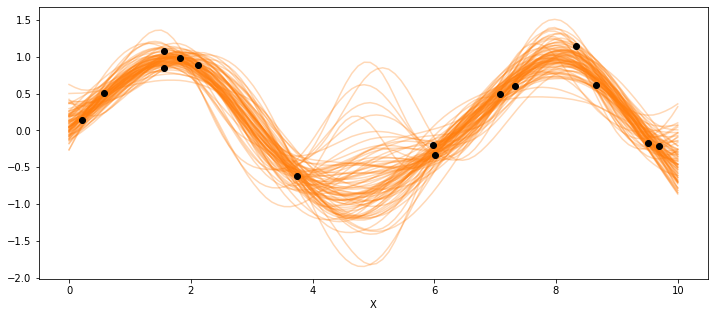

In [14]:
# cool plot
_, ax = plt.subplots(figsize = (12, 5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha = 0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.plot();

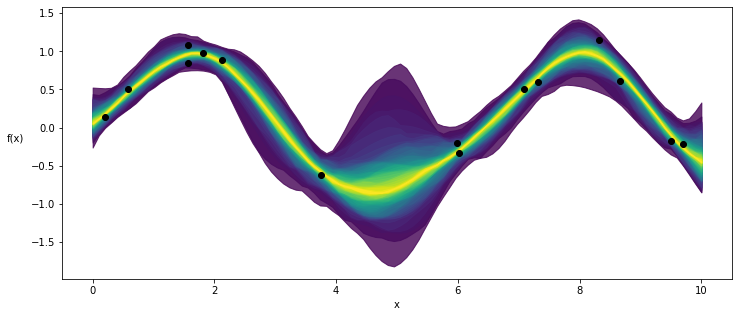

In [15]:
# cool plot 2
# our model is a bit more fucked..
_, ax = plt.subplots(figsize = (12, 5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, 
                       palette = 'viridis', plot_samples = False)

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation = 0, labelpad = 15)
plt.plot();

Text(0.5, 0, 'X')

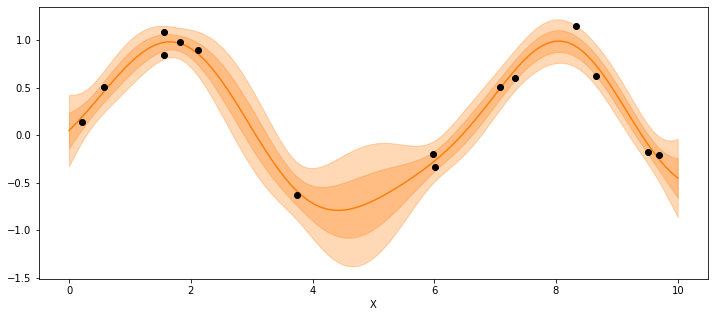

In [16]:
_, ax = plt.subplots(figsize = (12, 5))

point = {'l': md.get('trace')['l'].mean(), 'ϵ': md.get('trace')['ϵ'].mean()}
mu, var = gp.predict(X_new, point = point, diag = True)
sd = var**0.5

ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
               mu - sd, mu + sd,
               color = "C1",
               alpha = 0.3)

ax.fill_between(X_new.flatten(),
               mu - 2*sd, mu + 2*sd,
               color = "C1",
               alpha = 0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')

# Regression with spatial autocorrelation

In [22]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                         sep = ',', index_col = 0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [23]:
islands = pd.read_csv('../data/islands.csv', sep = ',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [24]:
# take out the relevant stuff
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

The model we are building 

$$f \sim GP([0, \dots, 0], K(x, x'))$$
$$\mu \sim exp(\alpha + \beta x + f)$$
$$y \sim Poisson(\mu)$$


In [25]:
with pm.Model() as model_islands:
    
    n = pm.HalfCauchy('n', 1) # \eta
    l = pm.HalfCauchy('l', 1)
    cov = n * pm.gp.cov.ExpQuad(1, ls = l) #only using one column rather than 10?
    gp = pm.gp.Latent(cov_func = cov)
    f = gp.prior('f', X = islands_dist_sqr)
    
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed = total_tools)
    trace_islands = pm.sample(1000, tune = 1000)

/home/victormp/.local/lib/python3.9/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, f_rotated_, l, n]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 361 seconds.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0, 0.5, 'covariance')

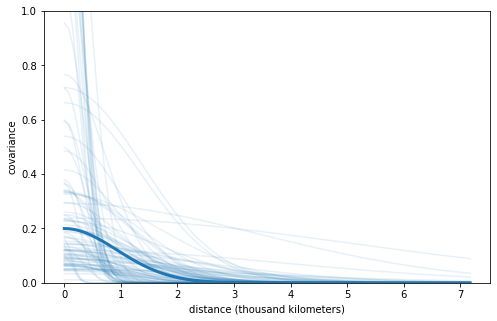

In [26]:
# plot some samples from posterior distribution
trace_n = trace_islands['n']
trace_l = trace_islands['l']

_, ax = plt.subplots(1, 1, figsize = (8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_n) * 
       np.exp(-np.median(trace_l) * xrange**2), lw = 3)

ax.plot(xrange, (trace_n[::20][:, None] * np.exp(- trace_l[::20][:, None] *
                                                xrange ** 2)).T,
       'C0', alpha = .1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [63]:
# potentially compare it to 
# m_10_10 in
# https:/​/​github.​com/​pymc-​devs/​resources

In [27]:
# compute posterior median cov. amoung societies
Σ = np.median(trace_n) * (np.exp(-np.median(trace_l) * islands_dist_sqr))

# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ) ** -0.5)
ρ = Σ_post @ Σ @ Σ_post # @ is matrix multiplication?
ρ = pd.DataFrame(ρ, index = islands_dist.columns,
                columns = islands_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.88,0.79,0.00,0.41,0.09,0.00,0.01,0.13,0.0
Ti,0.88,1.00,0.94,0.00,0.41,0.10,0.01,0.02,0.11,0.0
SC,0.79,0.94,1.00,0.00,0.25,0.18,0.02,0.04,0.05,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.03,0.24,0.22,0.00,0.0
Fi,0.41,0.41,0.25,0.00,1.00,0.00,0.00,0.00,0.71,0.0
Tr,0.09,0.10,0.18,0.03,0.00,1.00,0.15,0.66,0.00,0.0
Ch,0.00,0.01,0.02,0.24,0.00,0.15,1.00,0.42,0.00,0.0
Mn,0.01,0.02,0.04,0.22,0.00,0.66,0.42,1.00,0.00,0.0
To,0.13,0.11,0.05,0.00,0.71,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


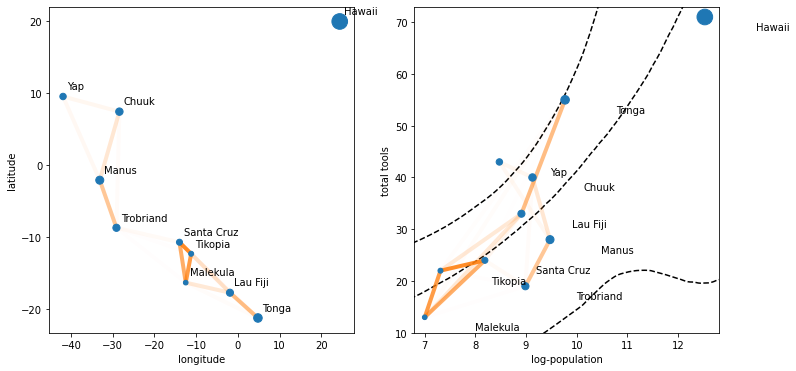

In [28]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max() #what!!
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] + 
                    trace_islands['β'][:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder = 3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder = 3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+1, islands.total_tools[i]-2.5, itext)
    
ax[1].plot(log_pop_seq, np.median(lambda_post, axis = 0), 'k--')
az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs = {'alpha': 0},
           plot_kwargs = {'color': 'k', 'ls': '--', 'alpha': 1})

for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                  (islands.lat[i], islands.lat[j]), 'C1-',
                  alpha = ρ.iloc[i, j]**2, lw = 4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                  (islands.total_tools[i], islands.total_tools[j]),
                  'C1-', alpha = ρ.iloc[i, j]**2, lw = 4)

ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.plot();

# Gaussian process classification

In [18]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [19]:
# some preprocessing
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [4]:
with pm.Model() as model_iris:
    l = pm.Gamma('l', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(cov_func = cov)
    f = gp.prior("f", X = X_1)
    
    #logistic inverse link function and bernoulli likelihood
    y_ = pm.Bernoulli("y", p = pm.math.sigmoid(f), observed = y)
    trace_iris = pm.sample(1000, chains = 1, 
                           compute_convergence_checks = False)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 87 seconds.


In [20]:
# posterior samples over range of values
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]

In [5]:

# crazy "LinAlgError: Matrix is not positive definite" error
with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris,
                                                 var_names = ['f_pred'],
                                                 samples = 1000)

LinAlgError: Matrix is not positive definite

In [21]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2


In [22]:
from scipy.stats import logistic

NameError: name 'pred_samples' is not defined

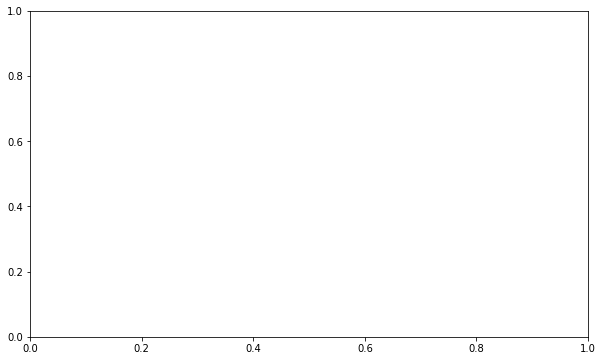

In [8]:
_, ax = plt.subplots(figsize=(10, 6))
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
marker='.', color=[f'C{x}' for x in y])
az.plot_hpd(X_new[:, 0], fp, color='C2')
db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_11.png')


In [23]:
# add white noise
# cov = K_{ExpQuad} + K_{Linear} + K_{whitenoise}(1E-5)

# re-do the model
with pm.Model() as model_iris2:
    l = pm.Gamma('l', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, l) +
        τ * pm.gp.cov.Linear(1, c) +
        pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris2 = pm.sample(1000, chains=1,
compute_convergence_checks=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, τ, c, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 144 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


In [32]:
# syntax changed
with model_iris2:
    pred3 = gp.conditional('pred3', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2,
                                                  var_names = ["pred3"],
                                                  samples=1000)

In [39]:
from scipy import stats
from scipy.special import expit as logistic

Text(0, 0.5, 'θ')

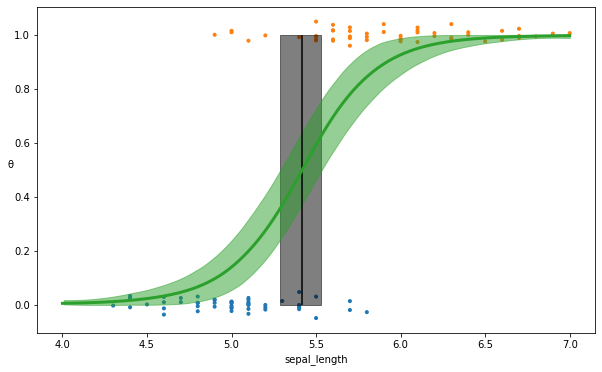

In [41]:
# plot it
_, ax = plt.subplots(figsize=(10,6))
fp = logistic(pred_samples['pred3'])
fp_mean = np.mean(fp, 0)
ax.scatter(x_1, np.random.normal(y, 0.02), marker='.',
           color=[f'C{ci}' for ci in y])
db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='k', alpha=0.5)
ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:,0], fp, color='C2')
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)


## Where we actually need a GP

[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

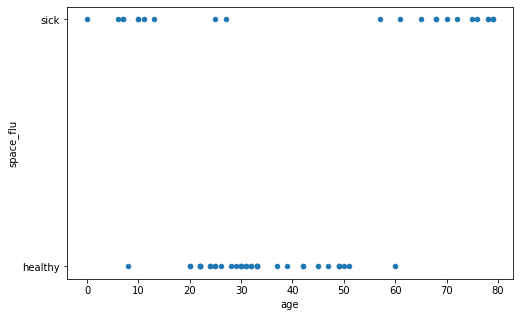

In [42]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu
ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])


In [43]:
# basically the same as model iris
with pm.Model() as model_space_flu:
    l = pm.HalfCauchy('l', 1)
    cov = pm.gp.cov.ExpQuad(1, l) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    trace_space_flu = pm.sample(1000, chains=2, compute_convergence_checks=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 107 seconds.


In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]
with model_space_flu:
    f_preddy = gp.conditional('f_preddy', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_space_flu,
                                                  var_names=["f_preddy"],
                                                  samples=1000)

Text(0.5, 0, 'age')

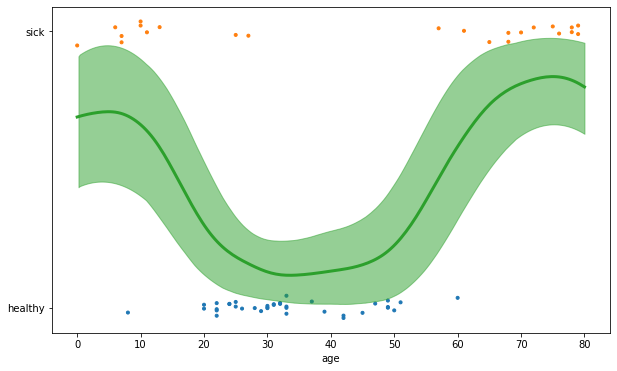

In [46]:
# plot
_, ax = plt.subplots(figsize=(10, 6))
fp = logistic(pred_samples['f_preddy'])
fp_mean = np.nanmean(fp, 0)
ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])
ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')


## Cox processes

In [47]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [48]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4


In [49]:
with pm.Model() as model_coal:
    l = pm.HalfNormal('l', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=l) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)
    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    trace_coal = pm.sample(1000, chains=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 55 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [51]:
?az.plot_hdi

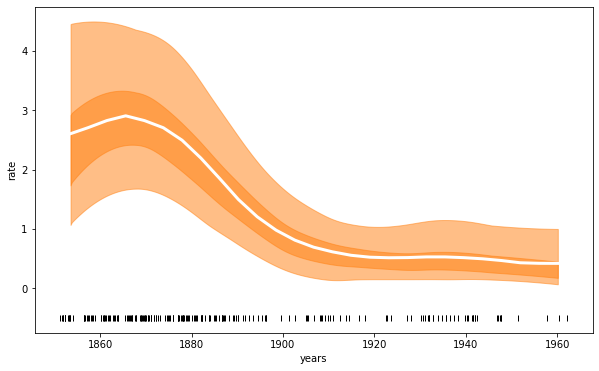

In [54]:
# plot results
_, ax = plt.subplots(figsize=(10, 6))
f_trace = np.exp(trace_coal['f'])
rate_median = np.median(f_trace, axis=0)
ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace, hdi_prob=0.95)
az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})
ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.plot();

## Redwood data set

Text(0, 0.5, 'x2 coordinate')

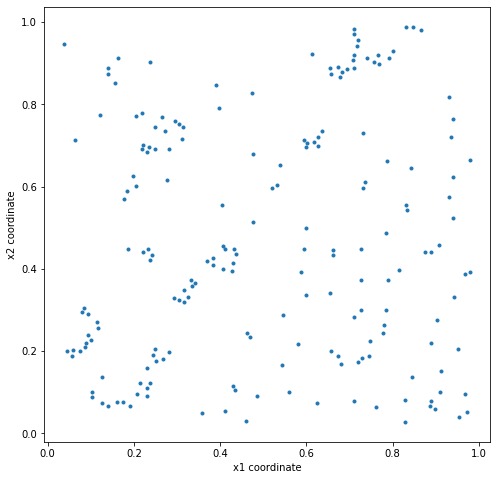

In [55]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')


In [56]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()


In [57]:
with pm.Model() as model_rw:
    l = pm.HalfNormal('l', rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=l[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=l[1])
    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)
    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 258 seconds.
The number of effective samples is smaller than 25% for some parameters.


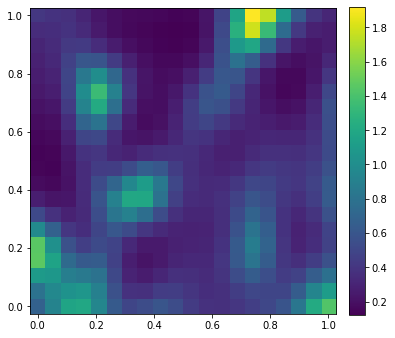

In [58]:
rate = np.exp(np.mean(trace_rw['f'], axis=0).reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)


# Exercises

1. For the example in the Covariance functions and kernels section make sure you
understand the relationship between the input data and the generated
covariance matrix. Try using other input such as data =
np.random.normal(size=4)


In [60]:
def exp_quad_kernel(x, knots, l = 1): 
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*l**2)) for k in knots])

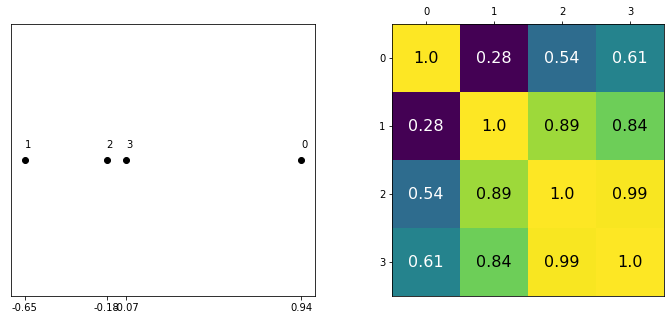

In [61]:
data = np.random.normal(size = 4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                  color = colors[int(im.norm(cov[i, j]) > 0.5)],
                  ha = 'center', va = 'center', fontdict = {'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

I guess it just is that the closer they are together (on the x-axis here, or whatever we imagine) the closer we expect them to be on the y-axis, correct?

2. Rerun the code generating Figure 7.3 and increase the number of samples
obtained from the GP-prior to around 200. In the original figure the number of
samples is 2. Which is the range of the generated values?


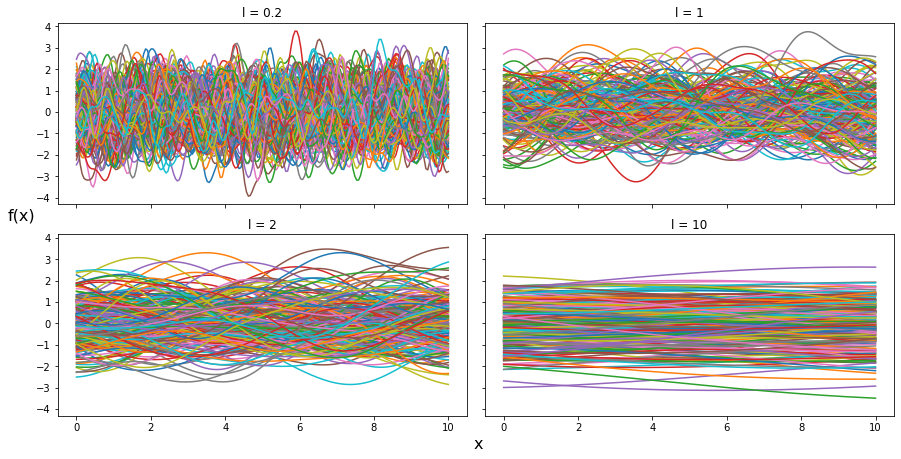

In [189]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize = (12, 6), 
                      sharex = True, sharey = True, 
                      constrained_layout = True)
ax = np.ravel(ax)
for idx, l in enumerate((0.2, 1, 2, 10)): 
    cov = exp_quad_kernel(test_points, test_points, l)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov = cov,
                                                           size = 200).T)
    ax[idx].set_title(f'l = {l}')

fig.text(0.51, -0.03, 'x', fontsize = 16)
fig.text(-0.03, 0.5, 'f(x)', fontsize = 16)
plt.plot();

What is the range of values? hmmm... 
within +-2 sd. 

3. For the generated plot in the previous exercise. Compute the standard deviation
for the values of y at each point. Do this in the following form: <br/>
(1) Visually, just observing the plots <br/>
(2) Directly from the values generated from stats.multivariate_normal.rvs <br/>
(3) By inspecting the covariance matrix (if you have doubts go back to exercise 1) <br/>
Did the values you get from these 3 methods agree?


Not done.

4. Re-run the model model_reg and get new plots but using as
test_points X_new np.linspace(np.floor(x.min()), 20,
100)[:,None]. What did you observed? How is this related to the specification
of the GP-prior?


Text(0, 0.5, 'f(x)')

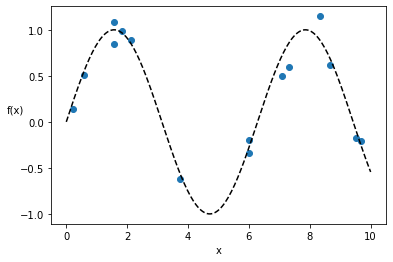

In [2]:
np.random.seed(42) # "random"
x = np.random.uniform(0, 10, size = 15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation = 0)

In [3]:
# one-dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for length scale kernel parameter
    l = pm.Gamma('l', 2, 0.5)
    
    # instantiate covariance function
    cov = pm.gp.cov.ExpQuad(1, ls = l)
    
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func = cov)
    
    # prior 
    ϵ = pm.HalfNormal('ϵ', 25)
    
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X = X, y = y, noise = ϵ)

In [4]:
with model_reg:
    
    trace = pm.sample(1000)
    post = pm.sample_posterior_predictive(trace, samples = 50)
    prior = pm.sample_prior_predictive(samples = 50)
    
    md = {'model': model_reg, 
         'trace': trace,
         'prior': prior,
         'post': post}

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
/home/victormp/.local/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'l'}>,
        <AxesSubplot:title={'center':'l'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

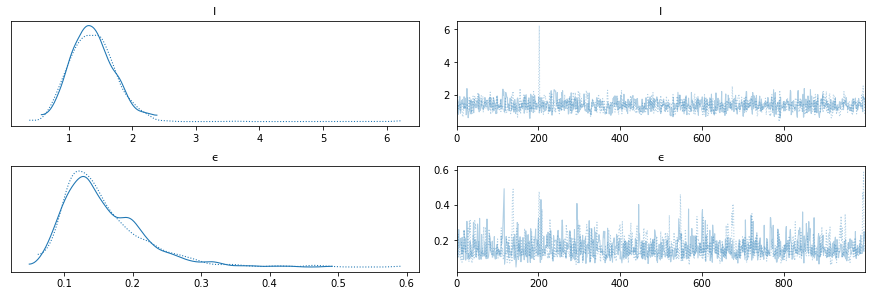

In [5]:
az.plot_trace(md.get('trace'))

In [6]:
# conditional distribution evaluated over new input locations
X_new = np.linspace(np.floor(x.min()), 20, 100)[:,None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [7]:
# now works
with model_reg:
    pred_samples = pm.sample_posterior_predictive(md.get('trace'), 
                                                 var_names = ["f_pred"], 
                                                 samples = 82)

/home/victormp/.local/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


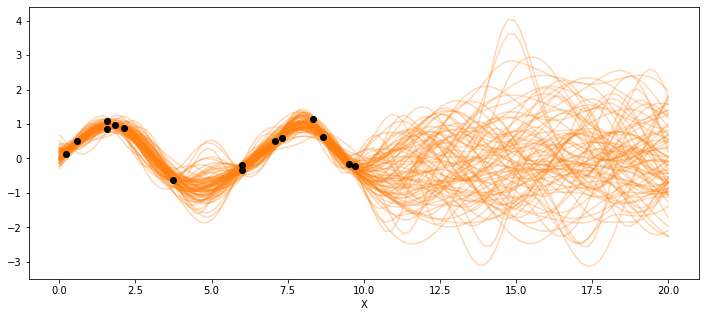

In [8]:
# cool plot
_, ax = plt.subplots(figsize = (12, 5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha = 0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.plot();

Yeah, so just gives us the range of X-values where we wish to predict (or draw) samples
from the gaussian process. Here we can see that it goes (rightfully) crazy after we loose points
that can constrain the function.

5. Go back to exercise 1, but this time use a linear kernel (see the accompanying
code for a linear kernel)


http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/#linear <br/>
a linear kernel should be:
$$ k(x, y) = x^T \cdot y + c $$ <br/>



In [46]:
# for reference (his quadratic exponential)
def exp_quad_kernel(x, knots, l = 1): 
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*l**2)) for k in knots])

In [209]:
data = np.array([1, 2, 3, 4])
x = 1

In [211]:
t = lin2(data, data)
t

array([[ 1,  0, -1, -2],
       [ 0,  0,  0,  0],
       [-1,  0,  1,  2],
       [-2,  0,  2,  4]])

In [196]:
def lin_kernel(x, knots): 
    """ linear kernel attempt? """
    return np.array([np.dot(x, k.T) for k in knots])

In [197]:
def lin2(x, knots): 
    return np.array([(x - 2) * (k - 2) for k in knots])

In [198]:
data = np.random.normal(size = 4)
cov = lin_kernel(data, data)

In [199]:
cov2 = lin2(data, data)

In [200]:
print(cov)
print(cov2)

[[ 5.7708424  -3.54976118 -2.32063988  2.09404492]
 [-3.54976118  2.18352947  1.42747225 -1.28808913]
 [-2.32063988  1.42747225  0.93320335 -0.84208228]
 [ 2.09404492 -1.28808913 -0.84208228  0.75985858]]
[[19.37987348  2.29940026  4.55182665 12.64195781]
 [ 2.29940026  0.27282126  0.54006913  1.49995412]
 [ 4.55182665  0.54006913  1.06910532  2.96926605]
 [12.64195781  1.49995412  2.96926605  8.24665328]]


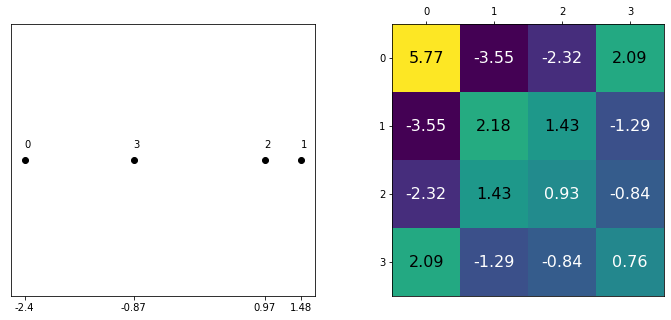

In [206]:
#data = np.random.normal(size = 4)
cov = lin_kernel(data, data)

_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                  color = colors[int(im.norm(cov[i, j]) > 0.5)],
                  ha = 'center', va = 'center', fontdict = {'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

Really don't know whether this is correct. 
Seems to fit the formula's I can find online. 
Perhaps it does not make sense with a regularizing
term when it is just linear.. 

In [56]:
from scipy import stats

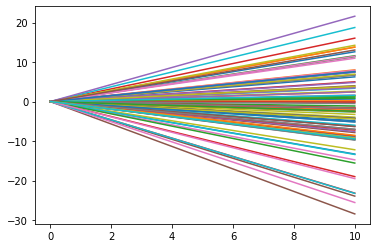

In [58]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)

cov = lin_kernel(test_points, test_points)
plt.plot(test_points, stats.multivariate_normal.rvs(cov = cov,
                                                size = 100).T)

#fig.text(0.51, -0.03, 'x', fontsize = 16)
#fig.text(-0.03, 0.5, 'f(x)', fontsize = 16)
plt.plot();

6. Go and check the section https:/​/​docs.​pymc.​io/​notebooks/​GP-​MeansAndCovs.
html from PyMC3' documentation


In [59]:
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

%matplotlib inline

np.random.seed(206)

In [60]:
# zero function
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
print(zero_func(X).eval())

[0. 0. 0. 0. 0.]


In [61]:
# constant function
const_func = pm.gp.mean.Constant(25.2)

print(const_func(X).eval())

[25.2 25.2 25.2 25.2 25.2]


In [62]:
# same for tt
const_func_vec = pm.gp.mean.Constant(tt.ones(5))

print(const_func_vec(X).eval())

[1. 1. 1. 1. 1.]


In [63]:
# linear
beta = np.random.randn(3)
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(5, 3)
print(lin_func(X).eval())

[-0.36242716  2.20718024  0.41039522  2.50735445 -2.06177178]


In [64]:
# custom
import theano.tensor as tt

class Constant(pm.gp.mean.Mean):

    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c

    def __call__(self, X):
        return tt.alloc(1.0, X.shape[0]) * self.c

In [67]:
# exponentiated quadratic
lengthscale = 0.2
eta = 2.0
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)

In [68]:
X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

In [76]:
?pm.MvNormal

In [73]:
test = pm.MvNormal.dist(mu = np.zeros(K.shape[0]), cov = K).random(size = 3).T

ValueError: input operand has more dimensions than allowed by the axis remapping

In [69]:
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

In [66]:
# exponentiated quadratic
lengthscale = 0.2
eta = 2.0
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

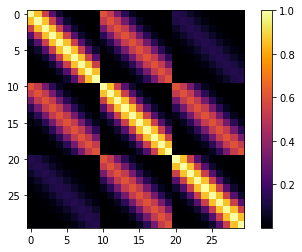

In [81]:
# higher dimensional input 
x1, x2 = np.meshgrid(np.linspace(0, 1, 10), np.arange(1, 4))
X2 = np.concatenate((x1.reshape((30, 1)), x2.reshape((30, 1))), axis=1)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m);

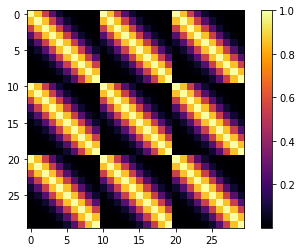

In [82]:
# one dimension active
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m);

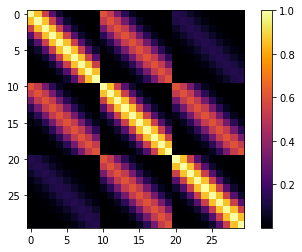

In [83]:
# first is similar to this
ls1 = 0.2
ls2 = 1.0
cov1 = pm.gp.cov.ExpQuad(2, ls1, active_dims=[0])
cov2 = pm.gp.cov.ExpQuad(2, ls2, active_dims=[1])
cov = cov1 * cov2

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m);

In [84]:
# generating white noise
sigma = 2.0
cov = pm.gp.cov.WhiteNoise(sigma)

X = np.linspace(0, 2, 200)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

ValueError: input operand has more dimensions than allowed by the axis remapping

<Figure size 1008x288 with 0 Axes>

Did not really have the energy to trouble-shoot this.. 
Does not seem to match anything particularly closely on google..

7. Run a logistic regression model for the space_flu data. What do you see? Can
you explain the result?


[Text(0, 0, 'healthy'), Text(0, 1, 'sick')]

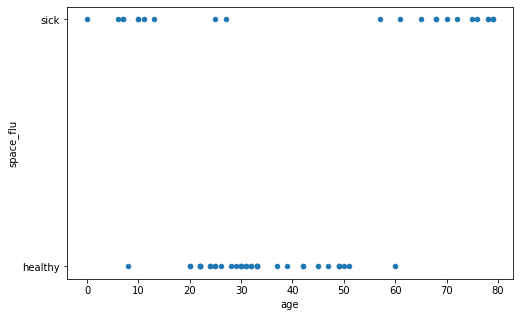

In [85]:
# load the data
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu
ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])

In [212]:
Y = pd.Categorical(space_flu).codes
age = age.flatten()
y_std = (Y - Y.mean()) / Y.std()
age_std = (age - age.mean()) / age.std()

In [213]:
# based on CH4 model of iris
# try with robust and/or standardize. 
with pm.Model() as logistic1:
    
    # priors 
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = 5)
    
    # mu (linear model)
    μ = pm.Deterministic('μ', α + age_std * β)
    
    # sigmoid 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    
    # boundary
    bd = pm.Deterministic('bd', -α/β)
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ

    # likelihood
    yl = pm.Bernoulli('yl', p = p, observed = y_std)
    
    # sample
    trace_log1 = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

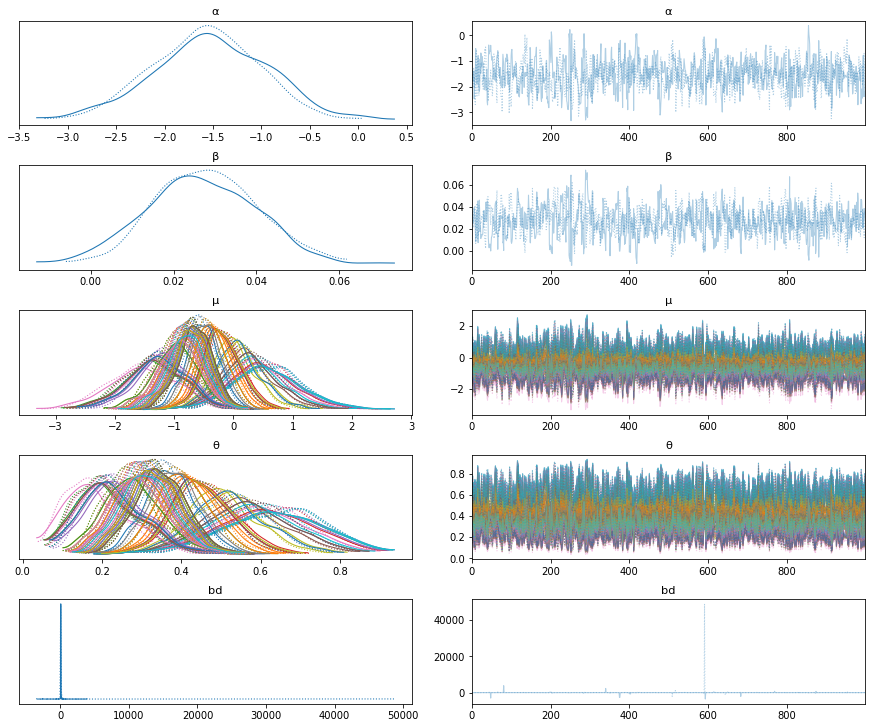

In [109]:
az.plot_trace(trace_log1)

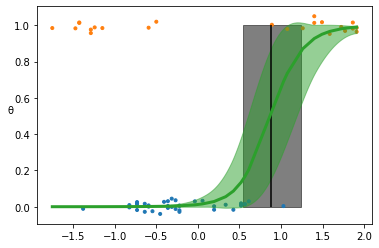

In [219]:
# hmm..
theta = trace_log1['θ'].mean(axis=0)
idx = np.argsort(age)
plt.plot(age_std[idx], theta[idx], color='C2', lw=3)
bd_hdi = az.hdi(trace_log1['bd'])
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)
plt.scatter(age_std, np.random.normal(Y, 0.02), marker='.', color=[f'C{x}' for x in Y])
az.plot_hdi(age_std, trace_log1['θ'], color='C2')
plt.vlines(trace_log1['bd'].mean(), 0, 1, color='k')
plt.ylabel('θ', rotation=0)
plt.plot();

8. Change the logistic regression model in order to fit the data. Tip, use an order
two polynomial.


In [220]:
age_total = np.stack((age_std, age_std**2), axis = 1)

In [221]:
# based on CH4 model of iris
with pm.Model() as logistic2:
    
    # priors 
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = 2, shape = 2) #two predictors now. 
    
    # mu (linear model)
    μ = α + pm.math.dot(age_total, β) 
    
    # sigmoid 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) #can just use sigmoid here. 
    
    # boundary
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * age_total[:, 0]) 
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ
    # likelihood
    yl = pm.Bernoulli('yl', p = θ, observed = Y)
    
    # sample
    trace_log2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>],
       [<AxesSubplot:title={'center':'π'}>,
        <AxesSubplot:title={'center':'π'}>]], dtype=object)

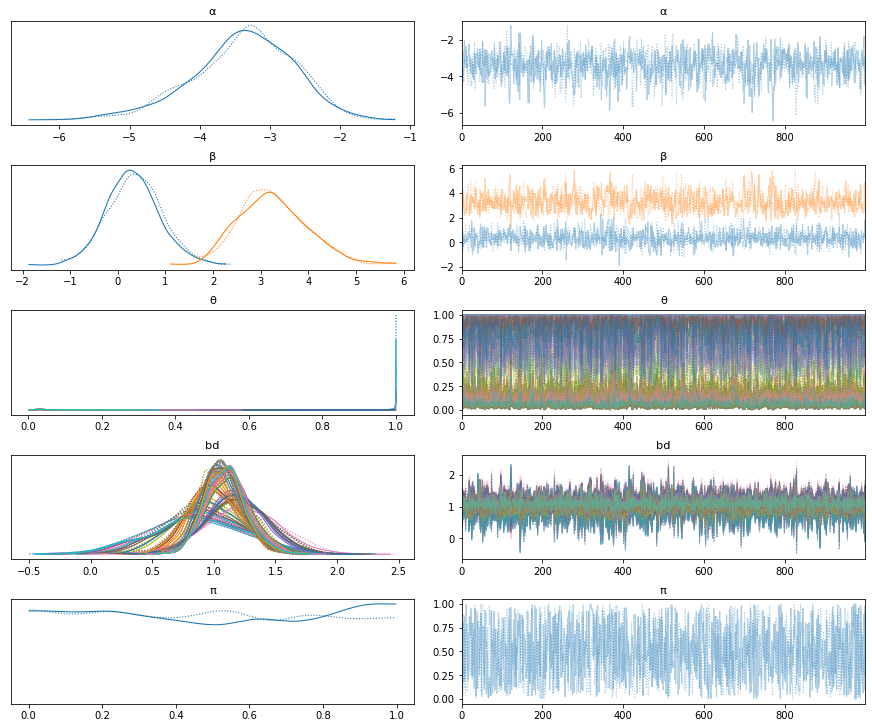

In [222]:
az.plot_trace(trace_log2) 

Text(0, 0.5, '[-0.73080669  0.53407842]')

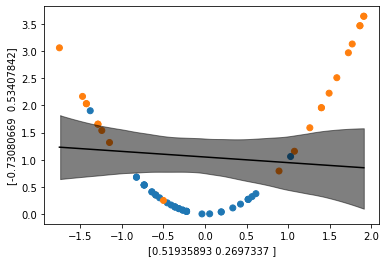

In [226]:
idx = np.argsort(age_total[:,0])
bd = trace_log2['bd'].mean(0)[idx]
plt.scatter(age_total[:,0], age_total[:,1], c=[f'C{x}' for x in Y])
plt.plot(age_total[:,0][idx], bd, color='k');
az.plot_hdi(age_total[:,0], trace_log2['bd'], color='k')
plt.xlabel(age_total[0])
plt.ylabel(age_total[1])


In [186]:
# https://towardsdatascience.com/building-a-bayesian-logistic-regression-with-python-and-pymc3-4dd463bbb16
df_sf = pd.read_csv('../data/space_flu.csv')
df_sf['age_sq'] = df_sf["age"] ** 2

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_sq, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


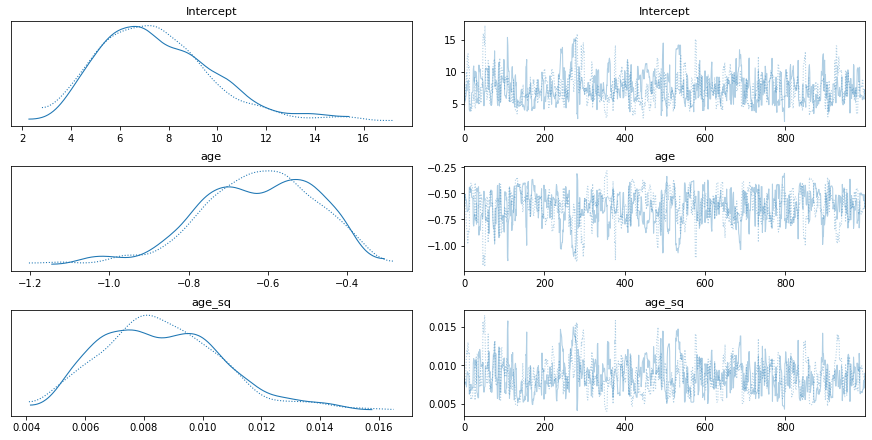

In [187]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('space_flu ~ age + age_sq', df_sf, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')
    
az.plot_trace(trace);

Hmmm.. would need more to actually do what we want.. 

9. Compare the model for the coal mining disaster with the one from the PyMC3
documentation (https:/​/​docs.​pymc.​io/​notebooks/​getting_​started.
html#Case-​study-​2:-​Coal-​mining-​disasters). Describe the differences between
both models in terms of model-specification and results.


Did not get here. 